1
t^2 - 1
t^2 - 1
[2, 2, 1, 1]
p1*p2
Ambient free module of rank 2 over the integral domain Univariate Polynomial Ring in a over Multivariate Polynomial Ring in p0, p1, p2, p3, p4, p5 over Rational Field
The factorization of meander determinant:  (t - 1)^131 * (t + 1)^131 * t^132 * (t^2 - 3)^10 * (t^2 - t - 1)^43 * (t^2 + t - 1)^43 * (t^2 - 2)^100 * (t^3 - t^2 - 2*t + 1) * (t^3 + t^2 - 2*t - 1)


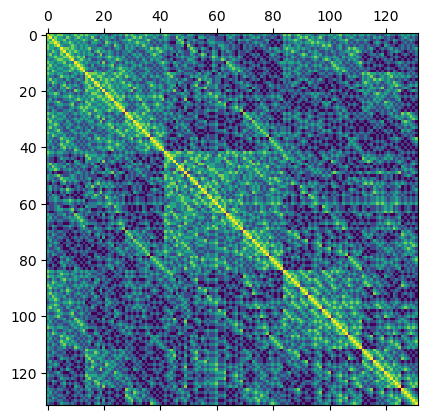

In [34]:
from sage.all import *
from __future__ import annotations

import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy.special import comb

from sage.combinat.combinatorial_map import combinatorial_map

from sage.structure.global_options import GlobalOptions
from sage.structure.parent import Parent
from sage.structure.unique_representation import UniqueRepresentation
from sage.categories.finite_enumerated_sets import FiniteEnumeratedSets
from sage.categories.infinite_enumerated_sets import InfiniteEnumeratedSets
from sage.categories.posets import Posets

from sage.rings.integer import Integer
from sage.rings.rational_field import QQ
from sage.combinat.permutation import Permutation, Permutations
from sage.combinat.words.word import Word
from sage.combinat.set_partition import SetPartitions
from sage.misc.latex import latex
from sage.misc.lazy_import import lazy_import
from typing import TYPE_CHECKING

from collections import Counter

def merge_sort(arr, start, end, compare):
    sorted_arr = [None] * (end - start + 1) 
    
    if start == end:
        sorted_arr[0] = arr[start]
        return sorted_arr

    left_start = start
    left_end = (start + end) // 2

    right_start = left_end + 1
    right_end = end

    left_sorted = merge_sort(arr, left_start, left_end, compare)
    right_sorted = merge_sort(arr, right_start, right_end, compare)

    i = 0  # current position in left part
    j = 0  # current position in right part

    k = 0

    while i < len(left_sorted) and j < len(right_sorted):
        a = left_sorted[i]
        b = right_sorted[j]
        decision = compare(a, b)
        if decision < 0:
            sorted_arr[k] = a
            i += 1
        else:
            sorted_arr[k] = b
            j += 1
        k += 1

    while i < len(left_sorted):
        sorted_arr[k] = left_sorted[i]
        i += 1
        k += 1

    while j < len(right_sorted):
        sorted_arr[k] = right_sorted[j]
        j += 1
        k += 1

    return sorted_arr

def dominanceCompare(x, y):
    poset = DyckWords().height_poset()
    if poset.le(x,y) and not poset.le(y,x):
        return -1
    if poset.le(y,x) and not poset.le(x,y):
        return 1
    else: 
        xp = x.peaks()
        yp = y.peaks()
        return (xp > yp) - (xp < yp)

def pVals(a, b, n):
    x = catalan_number(a);
    return x;

class Meander:
    def __init__(self, x, y):
        self.topDyck = x;
        self.botDyck = y;
        self.size = len(x)
        top_arches = [tuple(a0 + 1 if i == 0 else a0 for i, a0 in enumerate(a))
                       for a in x.tunnels()]
        bot_arches = [tuple(b0 + 1 if i == 0 else b0 for i, b0 in enumerate(b))
                       for b in y.tunnels()]

        self.topPerm = Permutation(top_arches)
        self.botPerm = Permutation(bot_arches)
        
        self.perm = self.botPerm.left_action_product(self.topPerm)
        self.order = len(self.perm.cycle_type())/2
        
    def getPerm(self):
        return self.perm.cycle_tuples();

    def getTop(self):
        return self.topPerm.cycle_tuples();

    def getBot(self):
        return self.botPerm.cycle_tuples();

    def getOrder(self):
        return self.order;

    def getCycleType(self):
        return self.perm.cycle_type()


def dyck_words(n):
    out=[]
    def rec(w,o,c):
        if o==n and c==n:
            out.append(DyckWord(w)); return
        if o<n: rec(w+'(', o+1, c)
        if c<o: rec(w+')', o, c+1)
    rec('',0,0); return out

def meanderMatrix(n):
    dws = dyck_words(n)
    arches = merge_sort(dws, 0, len(dws)-1, dominanceCompare)
    l = len(arches)
    mM = [[0]*l for _ in range(l)]
    
    for i in range(l):
        for j in range(i, l): 
            value = Meander(arches[i], arches[j]).getOrder()
            mM[i][j] = value
            mM[j][i] = value
    return mM

def stanleyPoly(m):
    R = PolynomialRing(QQ, m.size, "p")
    p = R.gens()
    entry = 1
    counts = Counter(m.getCycleType())
    for k in counts:
        entry *= p[k]^(counts[k]/2)
    return entry

def stanleyMatrix(n):
    dws = dyck_words(n)
    arches = merge_sort(dws, 0, len(dws)-1, dominanceCompare)
    l = len(arches)
    hM = [[0]*l for _ in range(l)]
    
    for i in range(l):
        for j in range(i, l): 
            m = Meander(arches[i], arches[j])
            value = stanleyPoly(m)
            hM[i][j] = value
            hM[j][i] = value
    return hM

def DFChebyshev(gen, k):
    return chebyshev_U(k, gen/2)

def c_nh(n, h):
    return comb(n,(n-h)/2, exact=true) - comb(n, (n-h)/2 - 1, exact=true)

def meanderDeterminant(M, n):
    R = PolynomialRing(QQ, 't')
    t = R.gen();
    mu = (t)
    ret = DFChebyshev(mu, 0)
    for i in range(n):
        m = i+1
        ret *= DFChebyshev(mu, m)^(c_nh(2*n,2*m)-c_nh(2*n,2*m+2))
    return ret

def terms(M, col = 1, row = 1):
    return [x[:col-1] + x[col:] for x in M[0:row-1] + M[row:]]

def detNxN(M):
    N = len(M[0])
    
    if (N == 2): 
        M = np.array(M)
        return M[0][0] * M[1,1] - M[0][1] * M[1][0]
    
    else: 
        rowValues = M[:1][0]
        colsSigns = [1 if (col % 2 == 0) else -1 for col in range(N)]
        colsDets = [detNxN(terms(M, col + 1)) for col in range(N)]
        return sum([rowValues[col] * colsSigns[col] * colsDets[col] for col in range(N)])

#m = Meander(y, x.reverse());
#print(m.topPerm);
#print(type(m.topPerm[0]));
#print(m.getTop());
#print(m.getBot());
#print(m.getPerm());
#d = dyck_words(6)
#mtest = Meander(DyckWord(d[0]), DyckWord(d[1]))
# print(mtest.getPerm());
# dws = DyckWords(3)
# mn = meanderMatrix(7)
# plt.matshow(mn)
# plt.show()

R = PolynomialRing(QQ, 't')
#print(R)
t = R.gen();
mu = (t)
#print(mu^catalan_number(3))
a = chebyshev_U(0, mu)
b = chebyshev_U(2, mu/2)
print(a)
print(b)
c = a*b
print(c)
x=DyckWord("(())()")
y=DyckWord("()()()")
m=Meander(x,y)
print(m.getCycleType())
print(stanleyPoly(m))
p = PolynomialRing(QQ, m.size, "p")
test = p["a"]^2
print(test)
M = meanderMatrix(6)
plt.matshow(M)
# print(detNxN(M))
dM = meanderDeterminant(M, 6)
# print(dM)
# print(dM(0))
print("The factorization of meander determinant: ", dM.factor())
H = stanleyMatrix(4)
# dH = detNxN(H)
# print(dH)
# print(dH.factor())
# for row in H:
    # print(row)
# P, L, U = scipy.linalg.lu(M)
# res = np.prod(np.diag(U))
# print(res)
# print(DFChebyshev(mu, 14))
# for m in range(5):
    # print(c_nh(2*5,2*m)-c_nh(2*5,2*m+2))
# print(c_nh(28,0))
# print(catalan_number(14))
# print(c_nh(28,30))
# print(comb(5,-1))


